In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import load_dataset, get_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

/home/user/conda/lib/python3.7/site-packages/librosa/core/constantq.py:1059: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.complex,


## Main Config

In [2]:
DEVICE_IDS = [0]

#DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
#DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'

# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

DATASET2, DATASET2_PATH = 'celeba_female_tensor', '/home/jovyan/data/tensor_female.pt'
DATASET1, DATASET1_PATH = 'celeba_male_tensor', '/home/jovyan/data/tensor_male.pt'

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64

BATCH_SIZE = 64

PLOT_INTERVAL = 100
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 500
MAX_STEPS = 100001
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../checkpoints3/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)

In [3]:
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, RandomCrop
from torchvision.datasets import ImageFolder

transform = Compose([Resize((64, 64)), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = ImageFolder('/home/jovyan/data/CelebA_HQ_face_gender_dataset', transform=transform)

male = []
female = []
lable = []

for i in tqdm(range(len(dataset))):
    _, l = dataset[i]
    if l:
        male.append(i)
        lable.append('1')
    else:
        female.append(i)
        lable.append('-1')

## Preparation

In [3]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## Loading data stats for testing

In [4]:
filename = './stats/celeba_female_64_test.json'
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

## Prepare Samplers (X, Y)

In [5]:
X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
    
torch.cuda.empty_cache(); gc.collect()
# clear_output()

11057
18943


60

In [7]:
for batch in tqdm(X_sampler.loader):
    pass

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/156 [00:00<?, ?it/s]

# Initializing Networks

In [6]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9715827
f params: 22933441


In [7]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

### Plots Test

/home/user/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


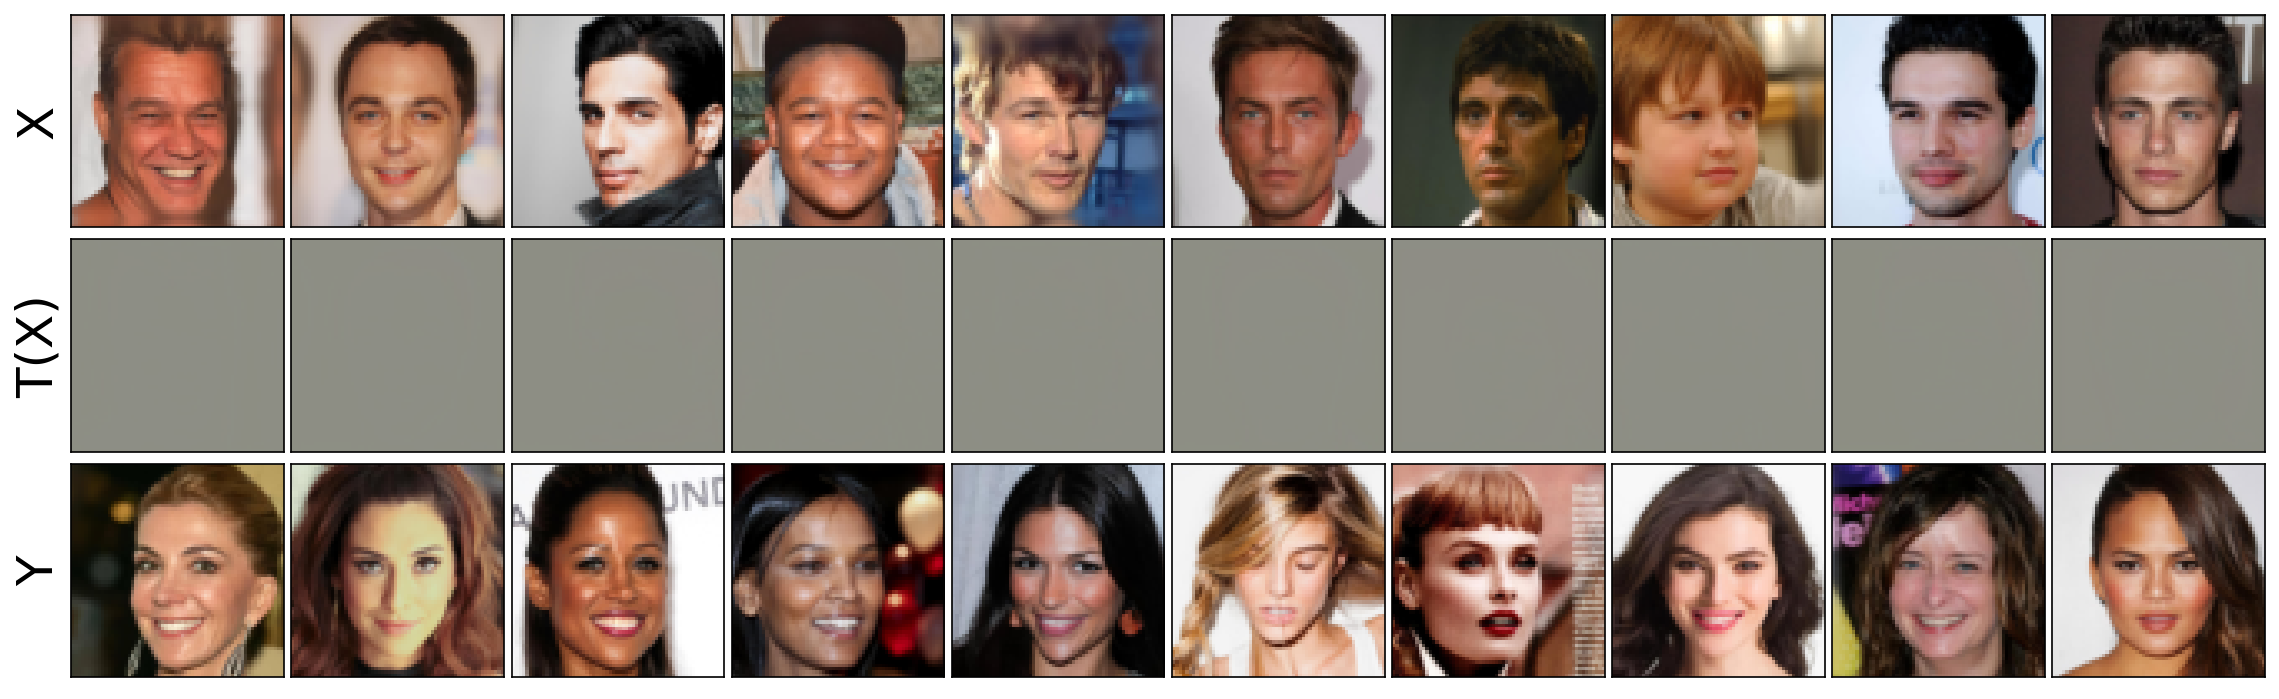

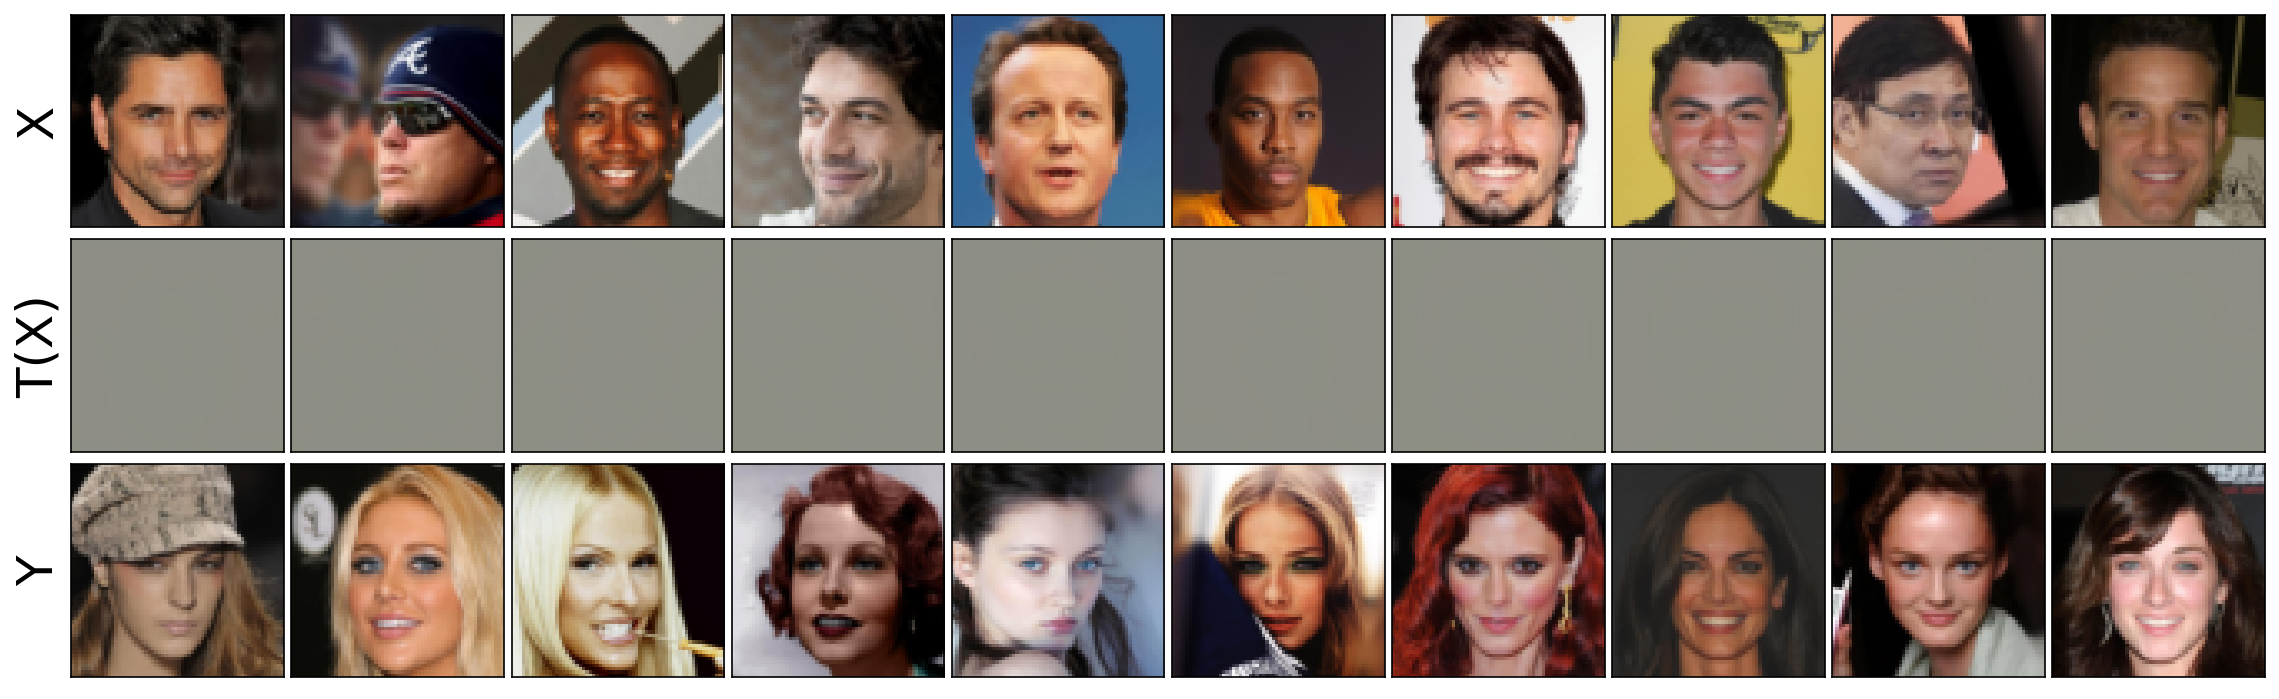

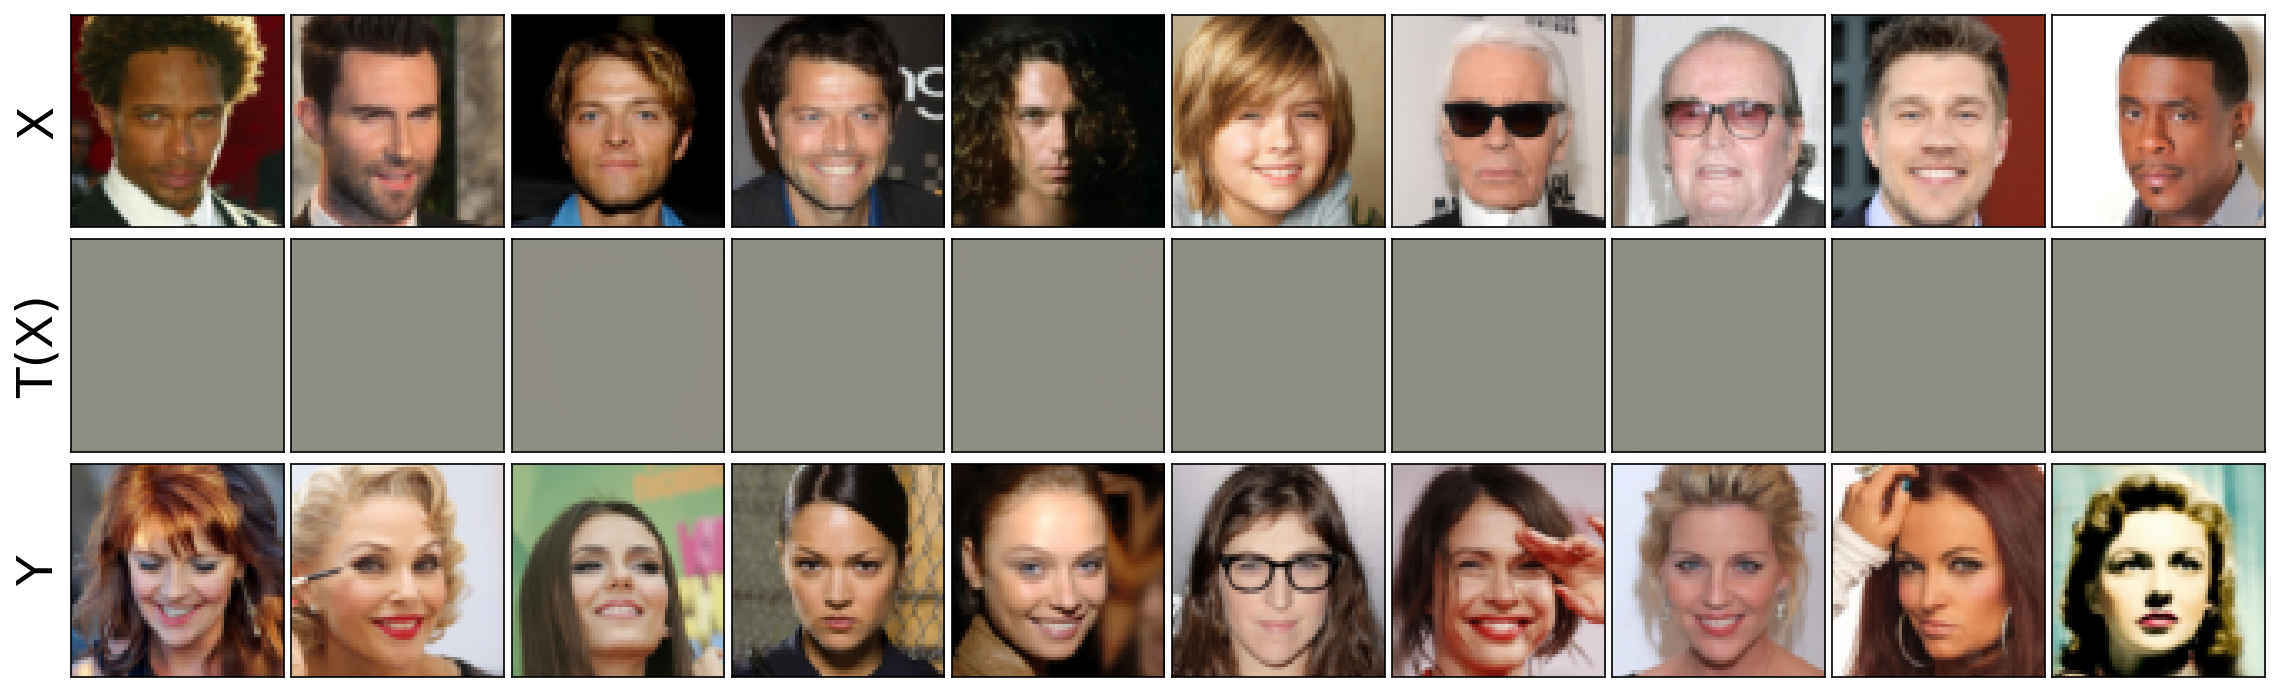

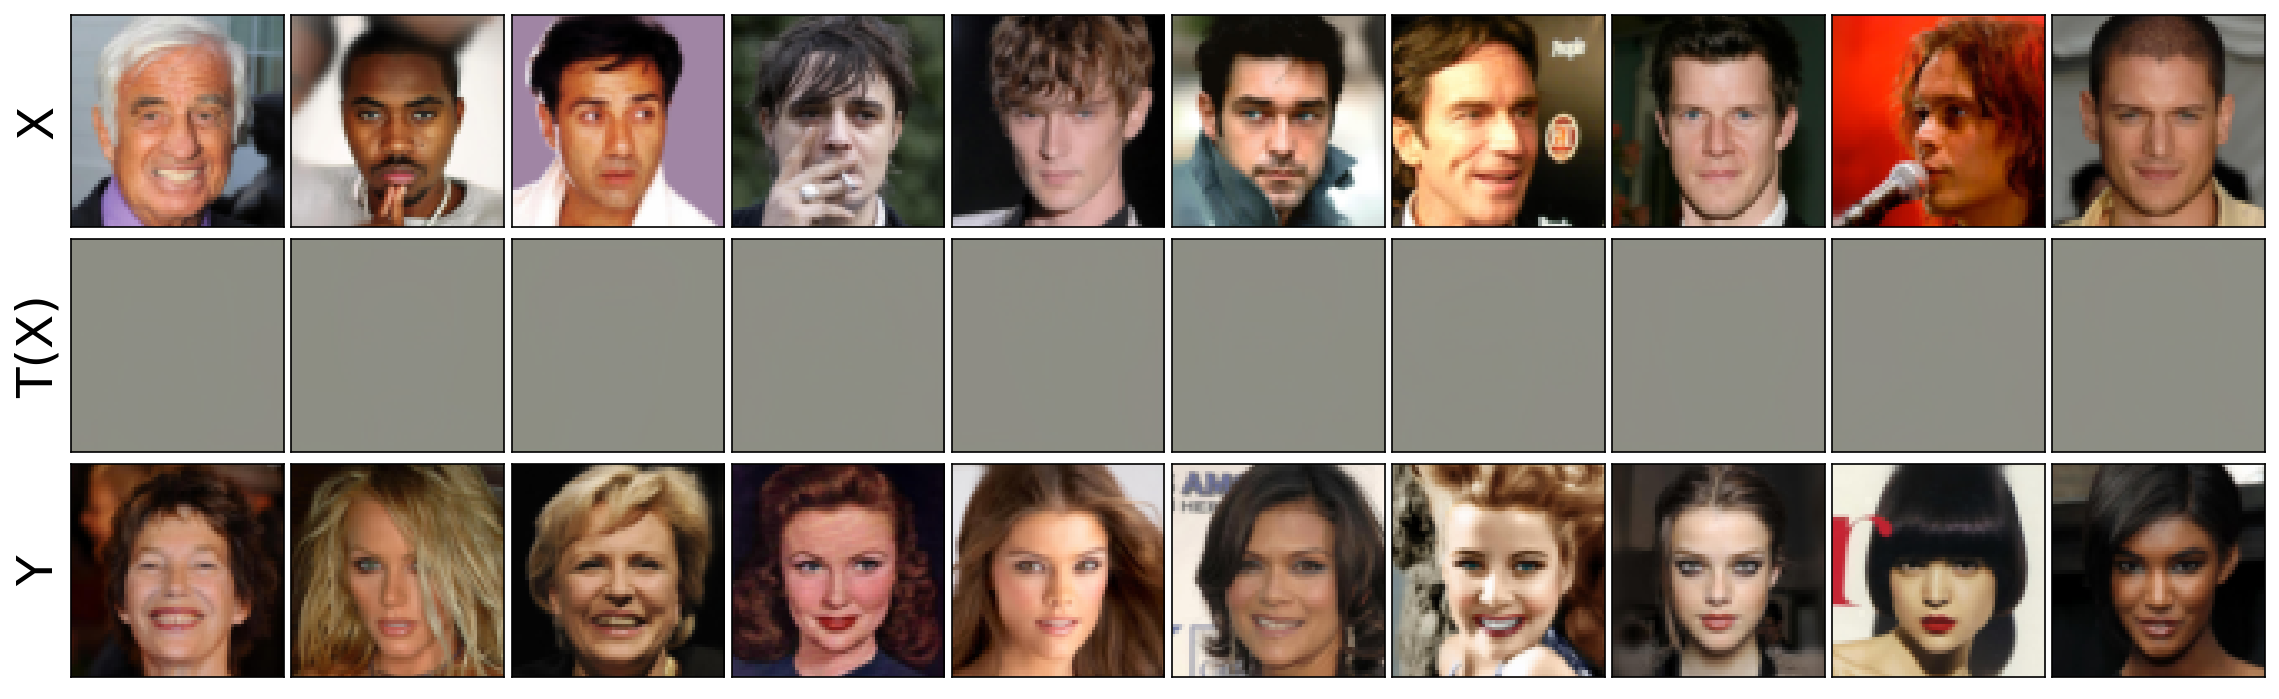

In [8]:
fig, axes = plot_images(X_fixed, Y_fixed, T)
fig, axes = plot_random_images(X_sampler, Y_sampler, T)
fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

# Run Training

In [9]:
wandb.init(name=EXP_NAME, project='notreallyweakot', entity='krv-valentin', config=config)
pass

/home/user/conda/lib/python3.7/site-packages/notebook/utils.py:282: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: krv-valentin. Use `wandb login --relogin` to force relogin


In [10]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-5, weight_decay=1e-10)

In [11]:
from glob import glob

checkpoint = glob('/home/jovyan/checkpoints2/*/*/*.pt')[-4:]

In [12]:
checkpoint

['/home/jovyan/checkpoints2/mse/celeba_male_tensor_celeba_female_tensor_64/0_15999.pt',
 '/home/jovyan/checkpoints2/mse/celeba_male_tensor_celeba_female_tensor_64/f_0_15999.pt',
 '/home/jovyan/checkpoints2/mse/celeba_male_tensor_celeba_female_tensor_64/f_opt_0_15999.pt',
 '/home/jovyan/checkpoints2/mse/celeba_male_tensor_celeba_female_tensor_64/T_opt_0_15999.pt']

In [13]:
T.load_state_dict(torch.load(checkpoint[0]))
f.load_state_dict(torch.load(checkpoint[1]))
T_opt.load_state_dict(torch.load(checkpoint[3]))
f_opt.load_state_dict(torch.load(checkpoint[2]))

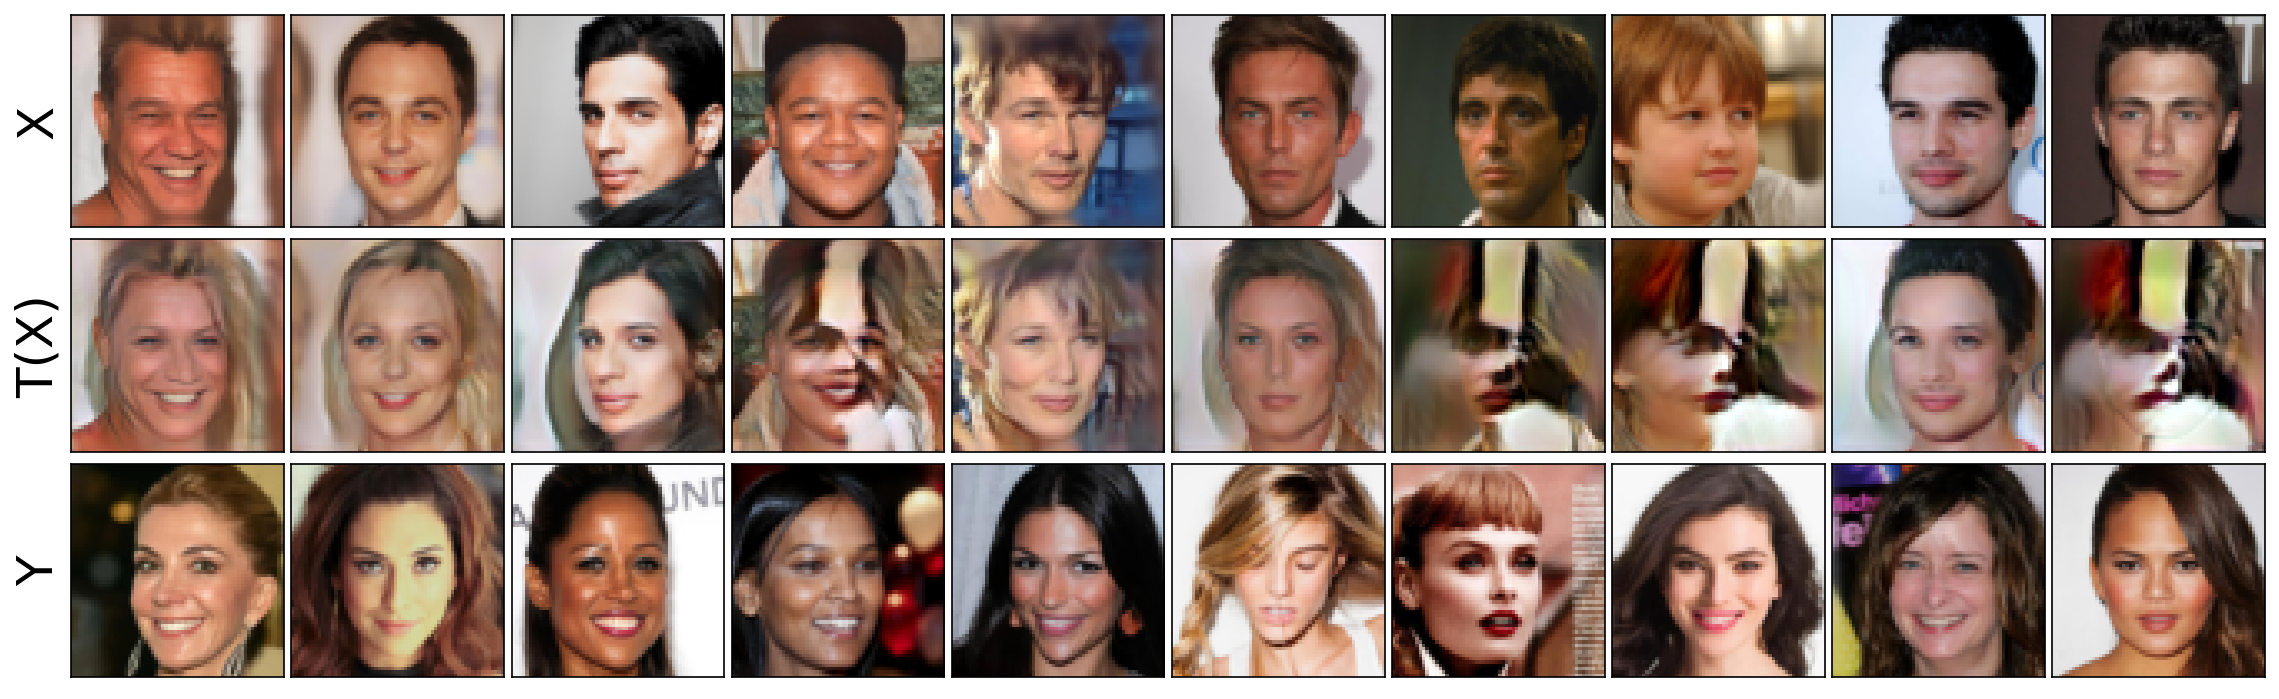

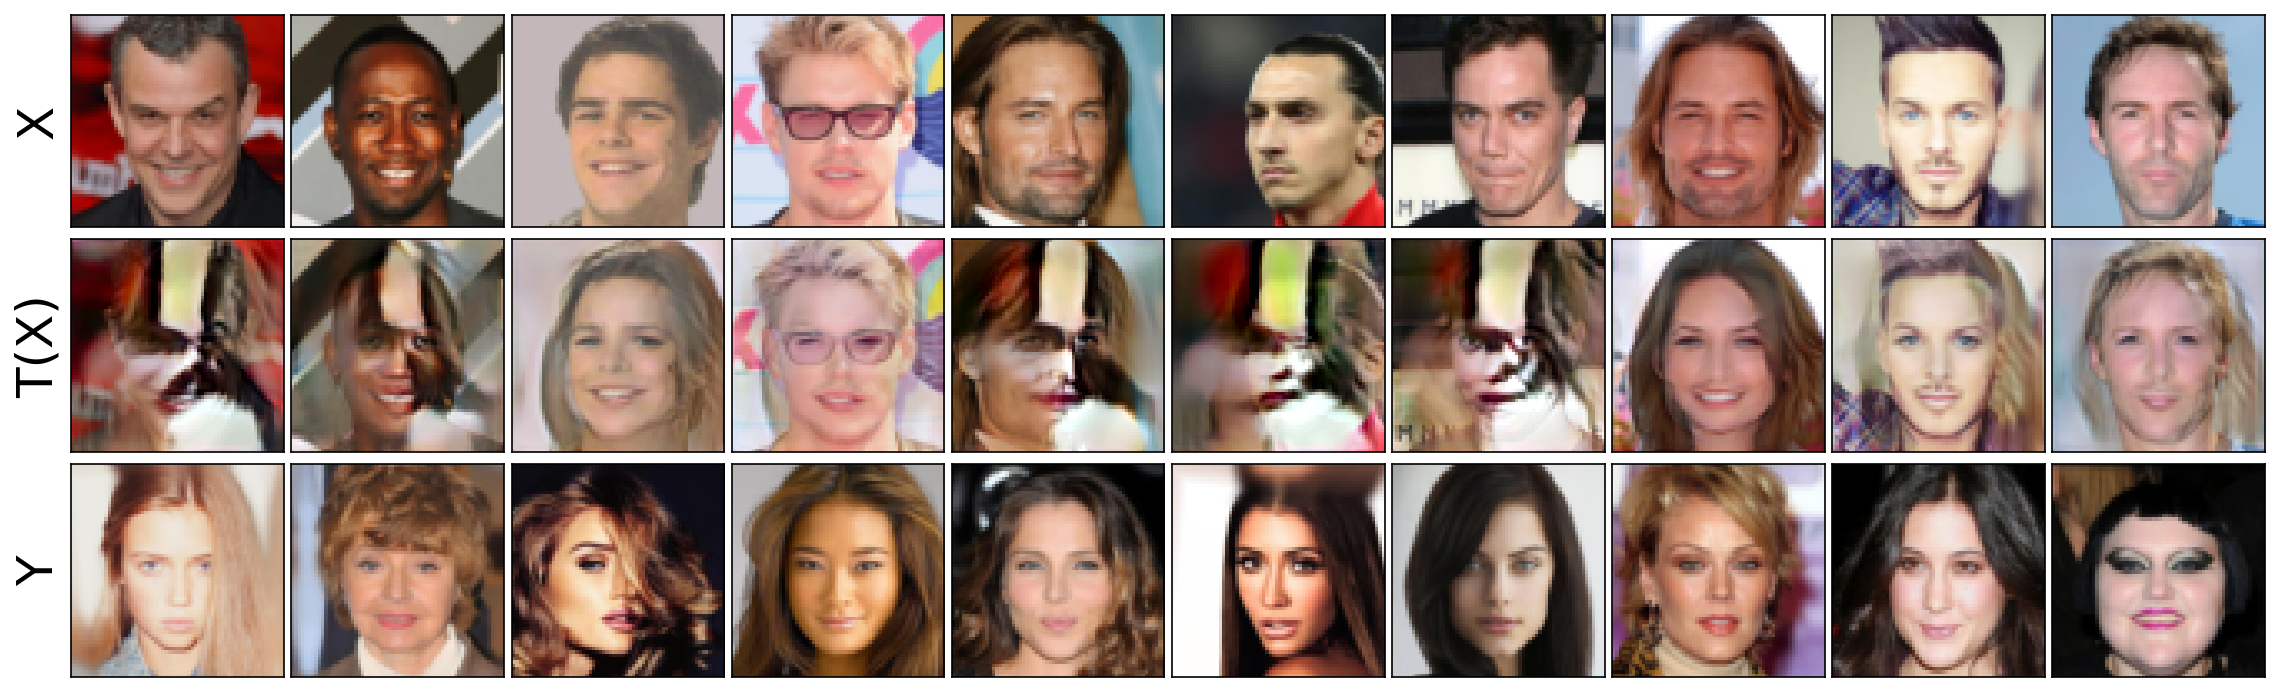

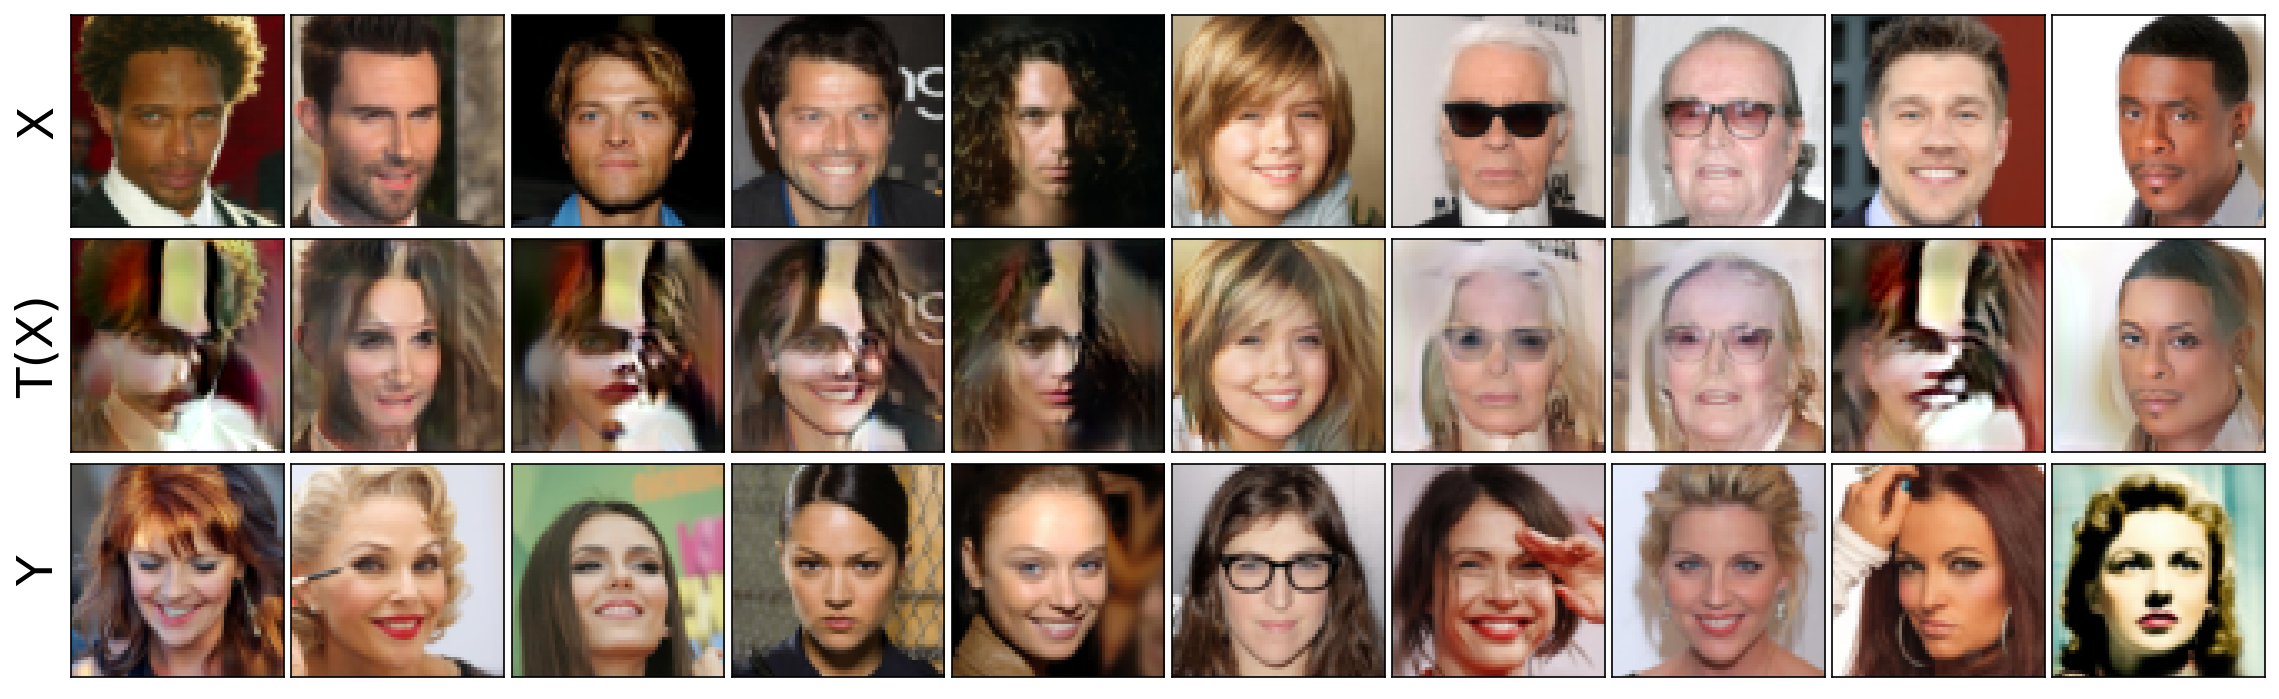

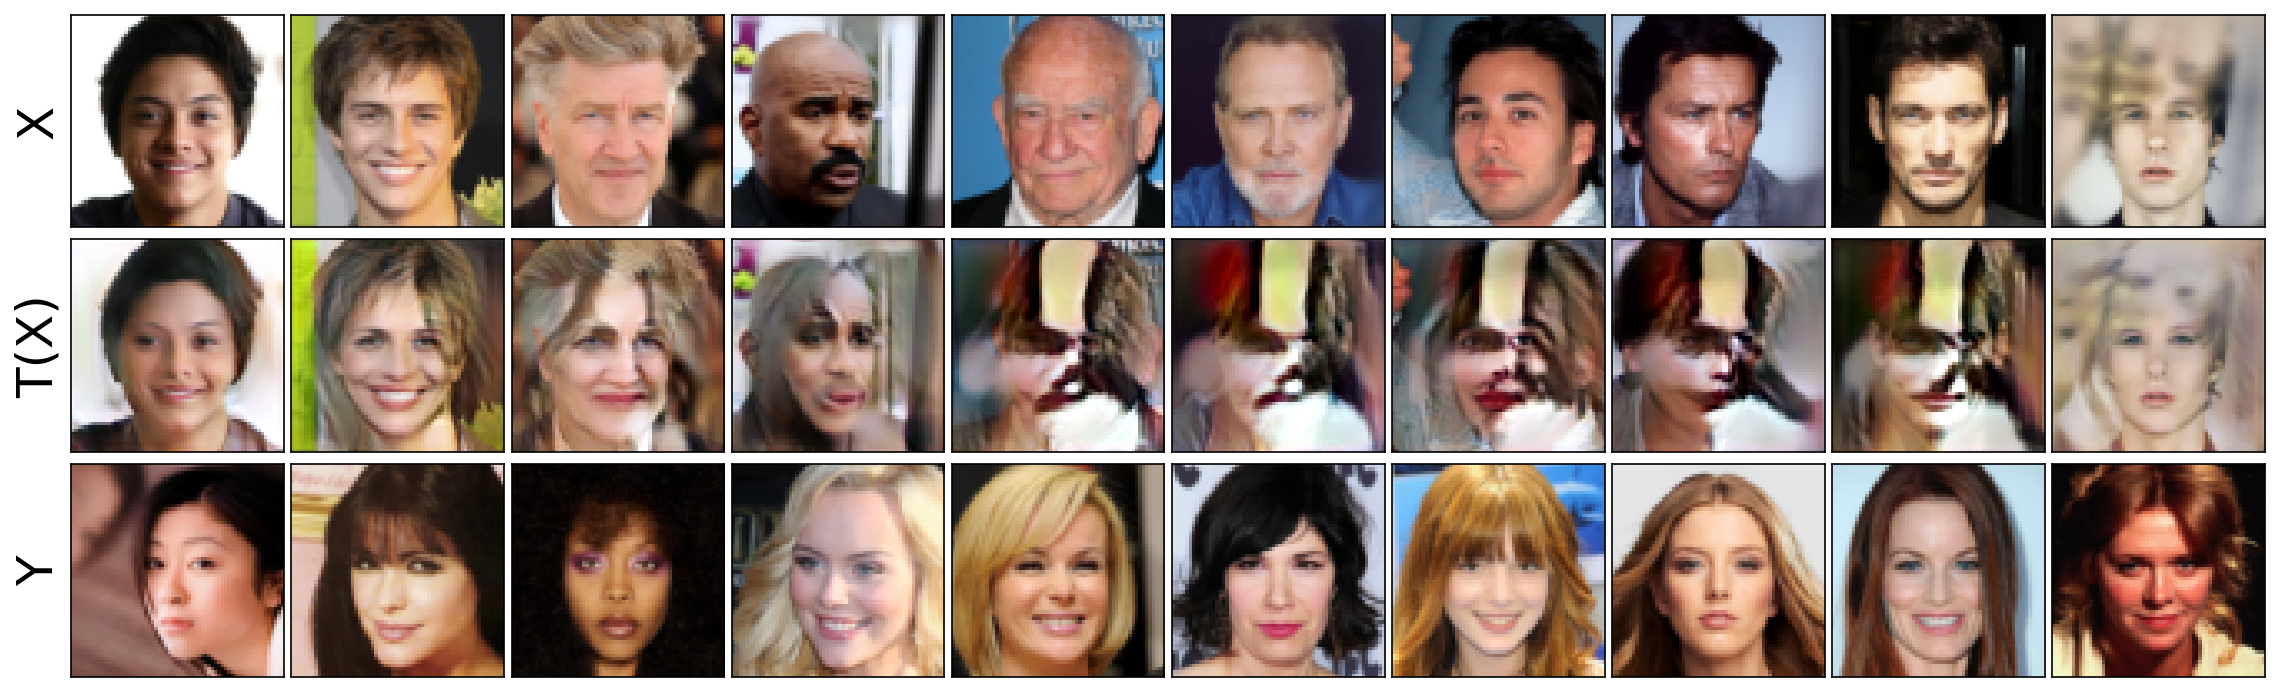

In [ ]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        T_X = T(X)
        if COST == 'mse':
            T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_X).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    wandb.log({f'f_loss' : f_loss.item()}, step=step) 
    del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
    
    if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
        freeze(T); 
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step)
        del mu, sigma
        
        torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
        torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
        torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
        torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
    gc.collect(); torch.cuda.empty_cache()